# XMM-LSS master catalogue

This notebook presents the merge of the various pristine catalogues to produce the HELP master catalogue on XMM-LSS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = '' #os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
#candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))           # 1.1
#cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
#cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
#cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6

servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7

#hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
#hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
#hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
#ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
#sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
#sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
#dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
#uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
#vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
#vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
#video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
#viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### Start with SERVS

In [5]:
master_catalogue = servs
master_catalogue['servs_ra'].name = 'ra'
master_catalogue['servs_dec'].name = 'dec'

### Add SWIRE

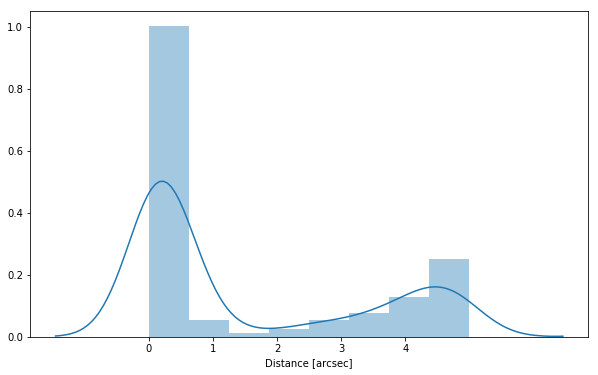

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(swire['swire_ra'], swire['swire_dec'])
)

In [7]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, swire, "swire_ra", "swire_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [8]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [9]:
master_catalogue[:10].show_in_notebook()

idx,servs_intid,ra,dec,f_ap_servs_irac_i1,ferr_ap_servs_irac_i1,f_servs_irac_i1,ferr_servs_irac_i1,servs_stellarity_irac_i1,f_ap_servs_irac_i2,ferr_ap_servs_irac_i2,f_servs_irac_i2,ferr_servs_irac_i2,servs_stellarity_irac_i2,m_ap_servs_irac_i1,merr_ap_servs_irac_i1,m_servs_irac_i1,merr_servs_irac_i1,flag_servs_irac_i1,m_ap_servs_irac_i2,merr_ap_servs_irac_i2,m_servs_irac_i2,merr_servs_irac_i2,flag_servs_irac_i2,servs_flag_cleaned,servs_flag_gaia,flag_merged,swire_intid,f_ap_swire_irac_i1,ferr_ap_swire_irac_i1,f_swire_irac_i1,ferr_swire_irac_i1,swire_stellarity_irac_i1,f_ap_swire_irac_i2,ferr_ap_swire_irac_i2,f_swire_irac_i2,ferr_swire_irac_i2,swire_stellarity_irac_i2,f_ap_irac_i3,ferr_ap_irac_i3,f_irac_i3,ferr_irac_i3,swire_stellarity_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,f_irac_i4,ferr_irac_i4,swire_stellarity_irac_i4,m_ap_swire_irac_i1,merr_ap_swire_irac_i1,m_swire_irac_i1,merr_swire_irac_i1,flag_swire_irac_i1,m_ap_swire_irac_i2,merr_ap_swire_irac_i2,m_swire_irac_i2,merr_swire_irac_i2,flag_swire_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,m_irac_i3,merr_irac_i3,flag_irac_i3,m_ap_irac_i4,merr_ap_irac_i4,m_irac_i4,merr_irac_i4,flag_irac_i4,swire_flag_cleaned,swire_flag_gaia
,,deg,deg,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,
0,3162305,36.4154798314,-4.49008512115,0.718295292801,0.250587644743,1.31749118101,0.439980876359,0.06,nan,nan,nan,nan,nan,24.259242449,0.378774692093,23.6006307079,0.362585475903,False,nan,nan,nan,nan,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
1,3163127,36.4165399314,-4.48931152115,2.21615593504,0.257678313459,3.59043740326,0.670623516261,0.24,nan,nan,nan,nan,nan,23.0359992117,0.126241420867,22.5121316012,0.202794297627,False,nan,nan,nan,nan,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
2,3161962,36.4135319314,-4.49085652115,0.477776458737,0.258243038268,0.573314363635,0.24654012409,0.35,nan,nan,nan,nan,nan,24.7019381321,0.586851468185,24.5040179435,0.466894875882,False,nan,nan,nan,nan,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
3,3161542,36.4127710314,-4.49207462115,0.454031108333,0.263729540715,0.515768207195,0.245684806889,0.35,nan,nan,nan,nan,nan,24.7572859752,0.630663197661,24.61886358,0.517187539047,False,nan,nan,nan,nan,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
4,3162472,36.4120258314,-4.49000042115,1.3932710461,0.266366568213,0.987010970513,0.196199388072,0.47,nan,nan,nan,nan,nan,23.5399109699,0.207571834393,23.9141950504,0.215824124904,False,nan,nan,nan,nan,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
5,3163180,36.4143863814,-4.48786632115,1.69466089281,0.266781827779,1.39743177305,0.263641279139,0.01,1.68869540671,0.574278389664,1.24780907819,0.435039522034,0.33,23.3272929813,0.170921917429,23.5366734663,0.204836391551,False,23.3311216948,0.369228717501,23.6596296477,0.378533998374,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
6,3161051,36.4122350314,-4.49337432115,0.394693524477,0.266897921851,0.310729301784,0.167926475829,0.35,nan,nan,nan,nan,nan,24.909349997,0.734191768443,25.1690444771,0.5867610

In [10]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['servs_intid'].astype(str)) 
                                    +  np.char.array(master_catalogue['swire_intid'].astype(str) )), 
                              name="irac_intid"))

In [11]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['servs_intid', 'swire_intid', 'irac_intid']


## VII - Choosing between multiple values for the same filter



### VII.a SERVS and SWIRE IRAC fluxes

Both SERVS and SWIRE provide IRAC1 and IRAC2 fluxes. SERVS is deeper but tends to under-estimate flux of bright sources (Mattia said over 2000 µJy) as illustrated by this comparison of SWIRE, SERVS, and Spitzer-EIP fluxes.

In [12]:
seip = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_XMM-LSS.fits")
seip_coords = SkyCoord(seip['ra'], seip['dec'])
idx, d2d, _ = seip_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
mask = d2d <= 2 * u.arcsec

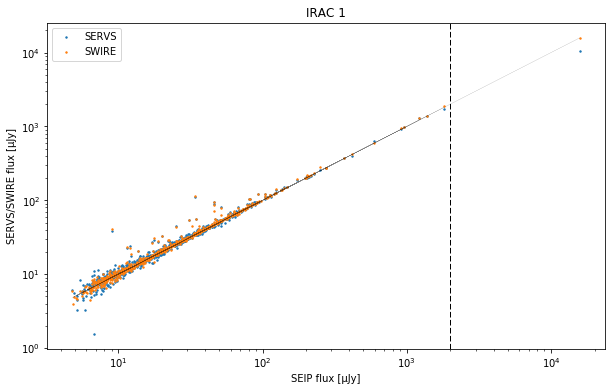

In [13]:
fig, ax = plt.subplots()
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i1'], label="SERVS", s=2.)
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i1'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 1")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)
ax.plot(seip['i1_f_ap1'][mask], seip['i1_f_ap1'][mask], linewidth=.1, color="black", alpha=.5);

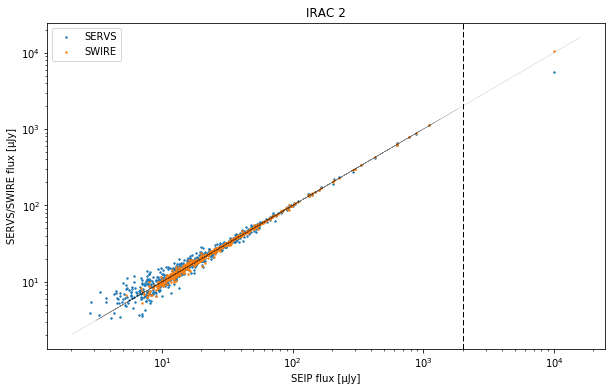

In [14]:
fig, ax = plt.subplots()
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i2'], label="SERVS", s=2.)
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i2'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 2")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)

ax.plot(seip['i1_f_ap2'][mask], seip['i1_f_ap2'][mask], linewidth=.1, color="black", alpha=.5);

When both SWIRE and SERVS fluxes are provided, we use the SERVS flux below 2000 μJy and the SWIRE flux over.

We create a table indicating for each source the origin on the IRAC1 and IRAC2 fluxes that will be saved separately.

In [15]:
irac_origin = Table()
irac_origin.add_column(master_catalogue['irac_intid'])

In [16]:
# IRAC1 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i1'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i1'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i1'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i1'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i1'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i1'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i1'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i1'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i1'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i1"))

master_catalogue.remove_columns(['f_ap_servs_irac_i1', 'f_ap_swire_irac_i1', 'ferr_ap_servs_irac_i1',
                                     'ferr_ap_swire_irac_i1', 'm_ap_servs_irac_i1', 'm_ap_swire_irac_i1',
                                     'merr_ap_servs_irac_i1', 'merr_ap_swire_irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC1_app"))

1776 sources with SERVS flux
735 sources with SWIRE flux
660 sources with SERVS and SWIRE flux
1775 sources for which we use SERVS
76 sources for which we use SWIRE


In [17]:
# IRAC1 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i1'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_servs_irac_i1'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_swire_irac_i1'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i1'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i1'][use_swire]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i1'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i1'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_servs_irac_i1'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_swire_irac_i1'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_servs_irac_i1'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_swire_irac_i1'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_irac_i1"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i1"))

master_catalogue.remove_columns(['f_servs_irac_i1', 'f_swire_irac_i1', 'ferr_servs_irac_i1',
                                 'ferr_swire_irac_i1', 'm_servs_irac_i1', 'flag_servs_irac_i1', 'm_swire_irac_i1',
                                 'merr_servs_irac_i1', 'merr_swire_irac_i1', 'flag_swire_irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC1_total"))

1776 sources with SERVS flux
735 sources with SWIRE flux
660 sources with SERVS and SWIRE flux
1775 sources for which we use SERVS
76 sources for which we use SWIRE


In [18]:
# IRAC2 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i2'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i2'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i2'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i2'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i2'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i2'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i2'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i2"))

master_catalogue.remove_columns(['f_ap_servs_irac_i2', 'f_ap_swire_irac_i2', 'ferr_ap_servs_irac_i2',
                                 'ferr_ap_swire_irac_i2', 'm_ap_servs_irac_i2', 'm_ap_swire_irac_i2',
                                 'merr_ap_servs_irac_i2', 'merr_ap_swire_irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_app"))

1856 sources with SERVS flux
507 sources with SWIRE flux
486 sources with SERVS and SWIRE flux
1855 sources for which we use SERVS
22 sources for which we use SWIRE


In [19]:
# IRAC2 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_servs_irac_i2'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_swire_irac_i2'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i2'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i2'][use_swire]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i2'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i2'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_servs_irac_i2'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_swire_irac_i2'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_servs_irac_i2'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_swire_irac_i2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_irac_i2"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i2"))

master_catalogue.remove_columns(['f_servs_irac_i2', 'f_swire_irac_i2', 'ferr_servs_irac_i2',
                                 'ferr_swire_irac_i2', 'm_servs_irac_i2', 'flag_servs_irac_i2', 'm_swire_irac_i2',
                                 'merr_servs_irac_i2', 'merr_swire_irac_i2', 'flag_swire_irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_total"))

1856 sources with SERVS flux
507 sources with SWIRE flux
486 sources with SERVS and SWIRE flux
1855 sources for which we use SERVS
22 sources for which we use SWIRE


In [20]:
irac_origin.write("{}/xmm-lss_irac_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

## XI - Saving the catalogue

In [21]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", 
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [22]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'swire_flag_gaia', 'swire_stellarity_irac_i2', 'servs_stellarity_irac_i1', 'swire_stellarity_irac_i1', 'servs_intid', 'swire_stellarity_irac_i3', 'servs_flag_gaia', 'swire_flag_cleaned', 'servs_stellarity_irac_i2', 'swire_intid', 'irac_intid', 'swire_stellarity_irac_i4', 'servs_flag_cleaned'}


In [23]:
master_catalogue.write("{}/irac_merged_catalogue_xmm-lss{}.fits".format(TMP_DIR, SUFFIX), overwrite=True)